In [8]:
import psycopg2
import sys
import pprint
import pandas
import random
from tableone import TableOne

In [9]:
def connect():
    "return a connection"
    conn_string = "host='localhost' dbname='mimic' user='postgres'"
    conn = psycopg2.connect(conn_string)
    return conn
    
def disconnect(conn):
    "disconnect"
    conn.commit()
    conn.close()

def get_data( query, itersize=10000):
    "return a pandas dataframe with columns names"
    conn = connect()
    cur = conn.cursor(f'tmpCursor')
    cur.itersize = itersize
    cur.execute(query)
    pd = pandas.DataFrame(cur.fetchall(),columns= [desc[0] for desc in cur.description])
    cur.close()
    disconnect(conn)
    return pd

def inStmt(col):
    "generates list"
    return ','.join(col.map(str))

In [10]:
# NOTES FROM ALISTAIR:
#
# - GCS should be < 13 because that's more consistent with sepsis 3 => DONE
# - You can get immature band forms from labevents as ITEMID = 51144 => OK CHAP2 INFLA
# - can you send me your pao2/fio2 analysis? Jerome and I think we should do FiO2 => THE CODE is row 146 of file angus2013.sql
# only before PaO2 - but it would be nice to really analyze the data and know all
# the details - I'd love to write up a notebook with all the details.
# - creatinine definition changed to >0.3 in 48 hours => DONE creatinine difference more than 0.3 in a 48 hour WINDOW; SAVES 2000 admissions
# - I plan to do a sensitivity analysis of the suspicion of infection definition,
# I'll try to forward you some results ASAP.


In [11]:
## ANGUS SEVERE
# 1) Les codes CIM9 
# 2) une periode WINDOW (un antibiotique 72h après une demande d'examen bacterio, ou 24h avant)
# 3) pas de vasopresseur pendant cette WINDOW
# TODO: remplissage => (liste à définir) eau administrée ?
# TODO: valider la liste de vasopresseur
# TODO: valider la liste des antibiotiques
angus_severe = get_data('SELECT hadm_id FROM sepsis.angus_deliberation WHERE type = 1')
angus_severe = set(angus_severe['hadm_id']) 

In [12]:
## ANGUS SHOCK
# 1) Les codes CIM9 
# 2) une periode WINDOW (un antibiotique 72h après une demande d'examen bacterio, ou 24h avant)
# 3) des vasopresseur pendant cette WINDOW
angus_shock = get_data('SELECT hadm_id FROM sepsis.angus_deliberation WHERE type = 2')
angus_shock = set(angus_shock['hadm_id']) 

In [13]:
#ACCP SIMPLE
# 1) dans infection icd9
# dans une fenetre de 24h :
# 2.) 2 critères dans chap general et inflamatory

accp_simple = get_data('SELECT distinct hadm_id FROM sepsis.accp_deliberation WHERE type = 1')          
accp_simple = set(accp_simple['hadm_id'])

In [14]:
# ACCP SEVERE: 
# 1) dans infection icd9
# dans une fenetre de 24h :
# 2.a) 2 critères dans chap general et inflamatory
# 2.b) 1 dans Soit organ disf SOIT tissue hypo SOIT émodynamique variable
## SEPSIS TOUT COURT: 2 crit dans general et inflamatory
accp_severe = get_data('SELECT distinct hadm_id FROM sepsis.accp_deliberation WHERE type = 2')          
accp_severe = set(accp_severe['hadm_id'])

In [15]:
#ACCP SHOCK
# 1) dans infection icd9
# dans une fenetre de 24h :
# 2.) 2 critères dans chap general et inflamatory

accp_shock = get_data('SELECT distinct hadm_id FROM sepsis.accp_deliberation WHERE type = 3')          
accp_shock = set(accp_shock['hadm_id'])

In [16]:
#Sepsis3 severe: 
# 1) dans infection icd9
# 2) sofa >= 2 
# 3) une periode WINDOW (un antibiotique 72h après une demande d'examen bacterio, ou 24h avant)
# pendant laquelles ils ont eu des lactate <= 2 ou pas de mesure de lactate,
# TODO?: si il y a eu des vasopresseurs alors retirer ceux avec lactate >2 
sofa = \
f'''
SELECT hadm_id
FROM sepsis.sepsis3_deliberation WHERE type =1
'''
sepsis3_severe = get_data(sofa)
sepsis3_severe = set(sepsis3_severe['hadm_id'])

In [17]:
#Sepsis3 shock: 
# 1) dans infection icd9
# 2) sofa >= 2 
# 3) une periode WINDOW (un antibiotique 72h après une demande d'examen bacterio, ou 24h avant)
# pendant laquelle ils ont eu des lactate > 2 
sofa = \
f'''
SELECT hadm_id
FROM sepsis.sepsis3_deliberation WHERE type =2
'''
sepsis3_shock = get_data(sofa)
sepsis3_shock = set(sepsis3_shock['hadm_id'])

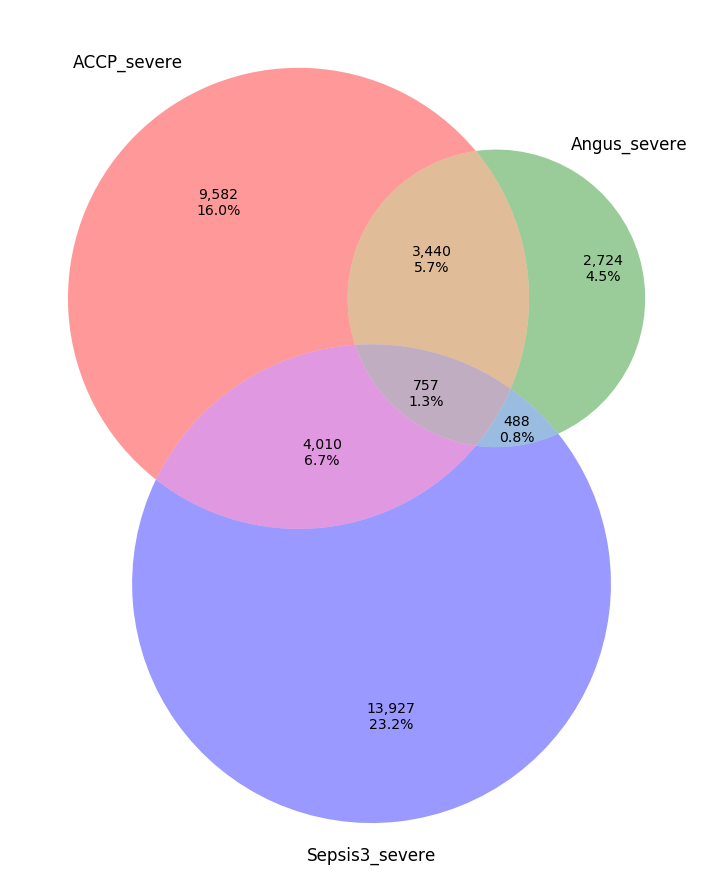

In [19]:
# PLOT DES SEVERE
import pylab as plt
from matplotlib_venn import venn3
plt.figure(figsize=[16,16])
plt.rcParams.update({'font.size': 14})
venn3([accp_severe, angus_severe, sepsis3_severe], ('ACCP_severe', 'Angus_severe', 'Sepsis3_severe'),      
subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/60000))
plt.savefig('sepsis3-venn.png')
plt.show()

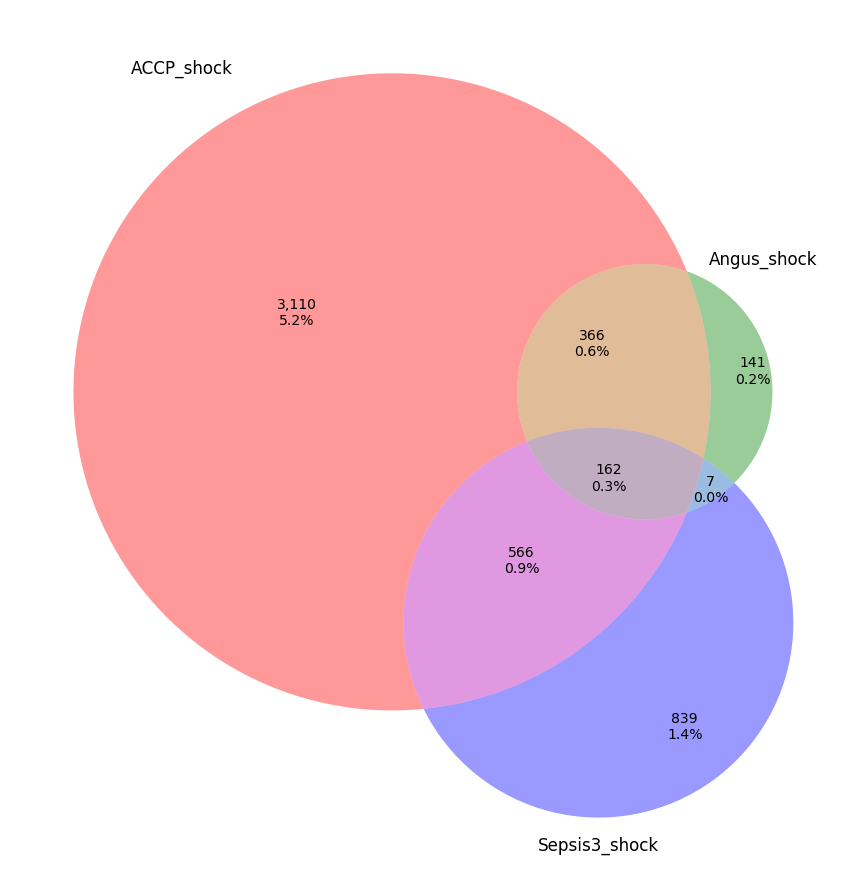

In [20]:
# PLOT DES SHOCK
import pylab as plt
from matplotlib_venn import venn3
plt.figure(figsize=[16,16])
plt.rcParams.update({'font.size': 14})
venn3([accp_shock, angus_shock, sepsis3_shock], ('ACCP_shock', 'Angus_shock', 'Sepsis3_shock'),      
subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/60000))
plt.savefig('sepsis3-venn-shock.png')
plt.show()

In [21]:
#### from tableone import TableOne
data = get_data( \
f'''
SELECT 
a.hadm_id,
p.gender, 
EXTRACT(year FROM age(a.admittime, p.dob)) as age, 
EXTRACT(epoch FROM a.dischtime - a.admittime)/3600 as length_admission, 
a.hospital_expire_flag as death_admission,
ad.type as accp_type
FROM mimiciii.admissions a
LEFT JOIN mimiciii.patients p USING (subject_id)
INNER JOIN sepsis.accp_deliberation ad USING (hadm_id)
'''
)
data.index.name='id'
data.head()

strat = 'accp_type'
convars = ['age', 'length_admission']

# list of columns containing categorical variables
catvars = ['death_admission',  'gender']
strat_table = TableOne(data, convars, catvars, strat)
strat_table

Stratified by accp_type
                               1                2                3
-----------------------------  ---------------  ---------------  ---------------
n                              6140             17789            4204
age (mean (std))               6.39 (23.64)     76.01 (58.04)    78.49 (56.09)
length_admission (mean (std))  253.09 (430.32)  319.22 (318.15)  434.66 (432.79)
death_admission (n (%))
0                              6110 (99.51)     15989 (89.88)    2512 (59.75)
1                              30 (0.49)        1800 (10.12)     1692 (40.25)
gender (n (%))
F                              2783 (45.33)     8352 (46.95)     1858 (44.20)
M                              3357 (54.67)     9437 (53.05)     2346 (55.80)

In [22]:
#### from tableone import TableOne
data = get_data( \
f'''
SELECT 
a.hadm_id,
p.gender, 
EXTRACT(year FROM age(a.admittime, p.dob)) as age, 
EXTRACT(epoch FROM a.dischtime - a.admittime)/3600 as length_admission, 
a.hospital_expire_flag as death_admission,
ad.type as angus_type
FROM mimiciii.admissions a
LEFT JOIN mimiciii.patients p USING (subject_id)
INNER JOIN sepsis.angus_deliberation ad USING (hadm_id)
'''
)
data.index.name='id'
data.head()

strat = 'angus_type'
convars = ['age', 'length_admission']

# list of columns containing categorical variables
catvars = ['death_admission',  'gender']
strat_table = TableOne(data, convars, catvars, strat)
strat_table

Stratified by angus_type
                               1                2
-----------------------------  ---------------  ---------------
n                              7409             676
age (mean (std))               82.83 (63.04)    75.09 (49.88)
length_admission (mean (std))  374.67 (350.29)  546.57 (549.52)
death_admission (n (%))
0                              5855 (79.03)     349 (51.63)
1                              1554 (20.97)     327 (48.37)
gender (n (%))
F                              3319 (44.80)     282 (41.72)
M                              4090 (55.20)     394 (58.28)

In [23]:
#### from tableone import TableOne
data = get_data( \
f'''
SELECT 
a.hadm_id,
p.gender, 
EXTRACT(year FROM age(a.admittime, p.dob)) as age, 
EXTRACT(epoch FROM a.dischtime - a.admittime)/3600 as length_admission, 
a.hospital_expire_flag as death_admission,
ad.type as sepsis3_type
FROM mimiciii.admissions a
LEFT JOIN mimiciii.patients p USING (subject_id)
INNER JOIN sepsis.sepsis3_deliberation ad USING (hadm_id)
'''
)
data.index.name='id'
data.head()

strat = 'sepsis3_type'
convars = ['age', 'length_admission']

# list of columns containing categorical variables
catvars = ['death_admission',  'gender']
strat_table = TableOne(data, convars, catvars, strat)
strat_table

Stratified by sepsis3_type
                               1                2
-----------------------------  ---------------  ---------------
n                              19182            1574
age (mean (std))               59.63 (59.79)    71.38 (51.43)
length_admission (mean (std))  249.43 (353.03)  421.56 (415.81)
death_admission (n (%))
0                              18247 (95.13)    1014 (64.42)
1                              935 (4.87)       560 (35.58)
gender (n (%))
F                              8464 (44.12)     665 (42.25)
M                              10718 (55.88)    909 (57.75)

In [24]:
#### from tableone import TableOne
data = get_data( \
f'''
SELECT 
a.hadm_id,
p.gender, 
EXTRACT(year FROM age(a.admittime, p.dob)) as age, 
EXTRACT(epoch FROM a.dischtime - a.admittime)/3600 as length_admission, 
a.hospital_expire_flag as death_admission,
CASE
WHEN sev.accp = 1 AND sev.angus = 1 AND sev.sepsis3 =1 THEN 'shr_severe'
WHEN sev.accp = 1 OR sev.angus = 1 OR sev.sepsis3 =1  THEN 'other_severe'
ELSE 'no severe'
END as severe_type
FROM mimiciii.admissions a
LEFT JOIN mimiciii.patients p USING (subject_id)
INNER JOIN sepsis.hadm_deliberation_severe as sev USING (hadm_id)
'''
)
data.index.name='id'
data.head()

strat = 'severe_type'
convars = ['age', 'length_admission']

# list of columns containing categorical variables
catvars = ['death_admission',  'gender']
strat_table = TableOne(data, convars, catvars, strat)
strat_table

Stratified by severe_type
                               no severe        other_severe     shr_severe
-----------------------------  ---------------  ---------------  ---------------
n                              24048            34171            757
age (mean (std))               58.84 (52.73)    67.27 (59.75)    81.56 (61.34)
length_admission (mean (std))  179.27 (209.56)  284.55 (338.81)  408.59 (390.03)
death_admission (n (%))
0                              21443 (89.17)    31020 (90.78)    659 (87.05)
1                              2605 (10.83)     3151 (9.22)      98 (12.95)
gender (n (%))
F                              10327 (42.94)    15323 (44.84)    376 (49.67)
M                              13721 (57.06)    18848 (55.16)    381 (50.33)

In [25]:
#### from tableone import TableOne
data = get_data( \
f'''
SELECT 
a.hadm_id,
p.gender, 
EXTRACT(year FROM age(a.admittime, p.dob)) as age, 
EXTRACT(epoch FROM a.dischtime - a.admittime)/3600 as length_admission, 
a.hospital_expire_flag as death_admission,
CASE
WHEN sev.accp = 1 AND sev.angus = 1 AND sev.sepsis3 =1 THEN 'shr_shock'
WHEN sev.accp = 1 OR sev.angus = 1 OR sev.sepsis3 =1  THEN 'other_shock'
ELSE 'no shock'
END as shock_type
FROM mimiciii.admissions a
LEFT JOIN mimiciii.patients p USING (subject_id)
INNER JOIN sepsis.hadm_deliberation_shock as sev USING (hadm_id)
'''
)
data.index.name='id'
data.head()

strat = 'shock_type'
convars = ['age', 'length_admission']

# list of columns containing categorical variables
catvars = ['death_admission',  'gender']
strat_table = TableOne(data, convars, catvars, strat)
strat_table

Stratified by shock_type
                               no shock         other_shock      shr_shock
-----------------------------  ---------------  ---------------  ---------------
n                              53785            5029             162
age (mean (std))               62.75 (57.16)    77.49 (56.39)    67.59 (35.45)
length_admission (mean (std))  225.91 (278.35)  419.95 (421.67)  501.38 (400.45)
death_admission (n (%))
0                              49857 (92.70)    3210 (63.83)     55 (33.95)
1                              3928 (7.30)      1819 (36.17)     107 (66.05)
gender (n (%))
F                              23757 (44.17)    2203 (43.81)     66 (40.74)
M                              30028 (55.83)    2826 (56.19)     96 (59.26)